In [1]:
import os
import sys

In [2]:
curr_path = !pwd
curr_path[0]

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/notebooks'

In [3]:
utils_path = os.path.join(os.path.dirname(curr_path[0]), 'utils')
utils_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/utils'

In [4]:
sys.path.append(utils_path)

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from DataLoader import CelebADataset
from PruningHelper import PruningHelper as ph
from torch.nn.utils.prune import global_unstructured, L1Unstructured
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Hyperparameters

In [7]:
SAMPLE_SEED = 42
K_FOLDS = 4
EPOCHS = 1

BATCH_SIZE = 64

### Dataset

In [8]:
data_path = os.path.join(os.path.dirname(curr_path[0]), '..', 'dataset/')
img_path = os.path.join(os.path.dirname(data_path), 'Img', 'img_align_celeba')
anno_path = os.path.join(os.path.dirname(data_path), 'Anno', 'list_attr_celeba.txt')
img_path, anno_path

('/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/../dataset/Img/img_align_celeba',
 '/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/../dataset/Anno/list_attr_celeba.txt')

In [9]:
dataset = CelebADataset(img_path, anno_path)

In [10]:
total_size = len(dataset)
total_size

202599

### Dataset split:

In [11]:
SAMPLE_SIZE = 3000

In [12]:
test_size = int(0.1 * SAMPLE_SIZE)
train_size = int(SAMPLE_SIZE - test_size)

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Data Sampling
sample_indices = torch.randperm(len(dataset))[:SAMPLE_SIZE]
ds_sample = Subset(dataset, sample_indices)
ds_train, ds_test = random_split(ds_sample, [train_size, test_size], generator=generator)
print(f"[Sampling] Train size: {len(ds_train)}, Test size: {len}")
# -----------End sampling ---------------


# TODO: Change to this, if training full dataset
# Data split
# indices = torch.randperm(len(dataset))
# ds_train, ds_test = random_split(dataset, [train_size, test_size], generator=generator)

# print(f"Train size: {len(ds_train)}, Test size: {len(ds_test)}")

[Sampling] Train size: 2700, Test size: <built-in function len>


In [13]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)

### Pruning settings


In [14]:
total_steps = ph.get_total_steps(len(ds_train), BATCH_SIZE, K_FOLDS, EPOCHS)
total_steps

128

In [15]:
PRUNE_START_STEP = 20
PRUNE_ITER_STEP = 10

In [16]:

pruning_schedule = ph.get_pruning_schedule(total_steps, pruning_start=PRUNE_START_STEP, pruning_interval=PRUNE_ITER_STEP)
pruning_rate = ph.get_pruning_rate(pruning_schedule, 0.9)
pruning_schedule, pruning_rate

([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 0.188869)

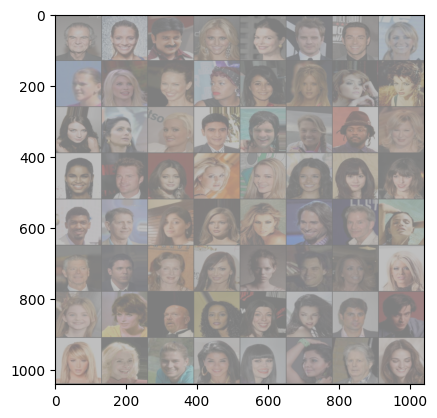

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 4 + 0.5
    npimg  =img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get random training img
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

# show img
imshow(torchvision.utils.make_grid(images))

In [18]:
def trainer(model, optimizer, pruning=False):
    criterion = nn.BCEWithLogitsLoss()

    kf = KFold(n_splits=K_FOLDS, shuffle=True)

    total_loss = []
    total_accuracy = []
    total_precision = []
    total_recall = []
    total_f1_score = []

    # Training
    step = 0
    num_of_prunes = 0
    for fold, (train_k, val_k) in enumerate(kf.split(ds_train)):

        train_loader_k = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(train_k))

        val_loader_k = DataLoader(
            dataset=ds_train,
            batch_size=BATCH_SIZE,
            sampler=torch.utils.data.SubsetRandomSampler(val_k)
        )

        model.train()
        for epoch in range(EPOCHS):
            epoch_loss = 0
            for imgs, lbls, _ in train_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device).float()

                outputs = model(imgs).squeeze(1)
                loss = criterion(outputs, lbls)
                epoch_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()

                # Add step
                step+=1

                # Pruning
                if pruning and (step in pruning_schedule):
                    num_of_prunes += 1
                    global_unstructured(
                        [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))],
                        pruning_method=L1Unstructured,
                        amount=pruning_rate,
                    )
                    print(f"[Step {step}]Num of prunes -> {num_of_prunes}\nTotal sparsity: {ph.get_sparsity(model)}")


                optimizer.step()
                
            avg_epoch_loss = epoch_loss / len(train_loader_k)
            total_loss.append(avg_epoch_loss)
            print(f"Fold: {fold+1}, Epoch: [{epoch + 1}/{EPOCHS}], Loss: {avg_epoch_loss:.7f}")

        # Evaluation of model
        model.eval()
        total=0
        correct=0
        y_pred = []
        y_true = []

        with torch.no_grad():
            for imgs, lbls, _ in val_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device).float()
                outputs = model(imgs).squeeze(1)
                predicted = (torch.sigmoid(outputs) > 0.5).float()

                y_true.extend(lbls.cpu().numpy()) #storing true values
                y_pred.extend(predicted.cpu().numpy()) #storing predictions
                total += lbls.size(0)
                correct += (predicted == lbls).sum().item()


        accuracy = correct / total
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

        total_accuracy.append(accuracy)
        total_precision.append(precision)
        total_recall.append(recall)
        total_f1_score.append(f1)

        print(f"Fold: [{fold + 1}/{K_FOLDS}], Accuracy: {accuracy}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    print(f"Avg. accuracy: {np.mean(total_accuracy):.2f}")
    print(f"Avg. precision: {np.mean(total_precision):.2f}")
    print(f"Avg. Recall: {np.mean(total_recall):.2f}")
    print(f"Avg. F1-score: {np.mean(total_f1_score):.2f}")

    print("Training Completed")
    print(f"Number of steps {step}")

    return model, total_loss, total_accuracy, total_precision, total_recall, total_f1_score

In [19]:
def test_model(model, test_loader):
    print("Test Evaluation")

    model.eval()
    y_pred_test = []
    y_true_test = []
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for imgs, lbls, _ in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).float()
            outputs = model(imgs).squeeze(1)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            y_true_test.extend(lbls.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

            total_samples += lbls.size(0)
            correct_predictions += (predicted == lbls).sum().item()

    accuracy = correct_predictions / total_samples
    precision_test = precision_score(y_true_test, y_pred_test, average='binary', zero_division=0)
    recall_test = recall_score(y_true_test, y_pred_test, average='binary', zero_division=0)
    f1_score_test = f1_score(y_true_test, y_pred_test, average='binary',zero_division=0)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Test precision: {precision_test:.2f}")
    print(f"Test recall: {recall_test:.2f}")
    print(f"Test f1-score: {f1_score_test:.2f}")

    print("Finished test evaluation!")

In [20]:
def plot_loss_curves(train_losses):
    if K_FOLDS != 4:
        return

    fig, axes = plt.subplots(1,4, figsize=(10,3))
    axes = axes.ravel()
    total_losses = len(train_losses)
    losses_per_fold = total_losses / K_FOLDS #Losses included per graph

    for graph in range(K_FOLDS):
        start_loss = int(graph * losses_per_fold)
        end_loss = int(start_loss + losses_per_fold)
        losses = np.array(train_losses[start_loss:end_loss])
        epochs = np.arange(1, EPOCHS + 1)

        axes[graph].plot(epochs, losses, linewidth=2)
        axes[graph].set_title(f'Fold {graph+1}', fontsize=12)
        axes[graph].set_xlabel('Epochs', fontsize=10)
        axes[graph].set_ylabel('Loss', fontsize=10)
        axes[graph].grid(True, linestyle='--', alpha=0.5)

        # Setting y-limits
        y_padding = 0.1 * (np.max(train_losses) - np.min(train_losses))
        axes[graph].set_ylim([np.min(train_losses) - y_padding,
                              np.max(train_losses) + y_padding])
        
    plt.suptitle(f"{K_FOLDS} Cross Validation Loss Curves", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### Initializing model

In [21]:
from ResNet import ResNet, BasicBlock

def ResNet18(num_classes=1):
    resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    return resnet

model = ResNet18().to(device)

In [22]:
resnet_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total # of params: {resnet_total_params}")

Total # of params: 11177025


### Choosing optimizer

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [24]:
np_trained_model, np_losses, np_total_accuracy, np_total_precision, np_total_recall, np_total_f1_score = trainer(model=model, optimizer=optimizer, pruning=False)

Fold: 1, Epoch: [1/1], Loss: 0.4086653
Fold: [1/4], Accuracy: 0.8681481481481481, Precision: 0.60, Recall: 0.41, F1-Score: 0.49
Fold: 2, Epoch: [1/1], Loss: 0.2412605
Fold: [2/4], Accuracy: 0.8977777777777778, Precision: 0.71, Recall: 0.59, F1-Score: 0.65
Fold: 3, Epoch: [1/1], Loss: 0.2171824
Fold: [3/4], Accuracy: 0.9096296296296297, Precision: 0.68, Recall: 0.76, F1-Score: 0.72
Fold: 4, Epoch: [1/1], Loss: 0.2082561
Fold: [4/4], Accuracy: 0.6296296296296297, Precision: 0.28, Recall: 0.95, F1-Score: 0.43
Avg. accuracy: 0.83
Avg. precision: 0.57
Avg. Recall: 0.68
Avg. F1-score: 0.57
Training Completed
Number of steps 128


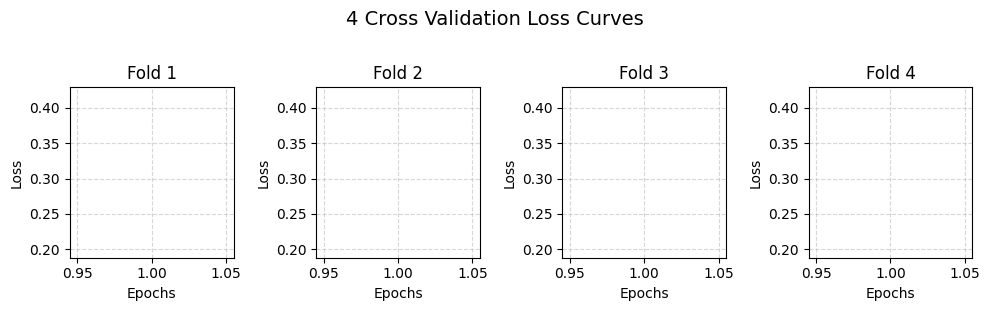

In [25]:
plot_loss_curves(np_losses)

In [26]:
ph.get_sparsity(np_trained_model) # Percentage of weights removed

0.0

In [27]:
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
test_model(model=np_trained_model,test_loader=test_loader)

Test Evaluation
Accuracy: 0.63
Test precision: 0.24
Test recall: 1.00
Test f1-score: 0.39
Finished test evaluation!


In [29]:
models_path = os.path.join(os.path.dirname(curr_path[0]), '..', 'models', 'test_models/')
models_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/../models/test_models/'

In [35]:
from datetime import datetime

current_time = datetime.now().strftime("%m_%d_%Y_%H_%M")
torch.save(np_trained_model, f'{models_path}/full_model_{current_time}.pth')

In [31]:
p_model = ResNet18().to(device)

In [32]:
p_optimizer = torch.optim.AdamW(p_model.parameters(), lr=0.001)

In [33]:
p_trained_model, p_losses, p_total_accuracy, p_total_precision, p_total_recall, p_total_f1_score = trainer(model=p_model, optimizer=p_optimizer, pruning=True)

[Step 20]Num of prunes -> 1
Total sparsity: 18.88689817812953
[Step 30]Num of prunes -> 2
Total sparsity: 34.206644253858364
Fold: 1, Epoch: [1/1], Loss: 0.3801247
Fold: [1/4], Accuracy: 0.7525925925925926, Precision: 0.34, Recall: 0.92, F1-Score: 0.50
[Step 40]Num of prunes -> 3
Total sparsity: 46.63296566871644
[Step 50]Num of prunes -> 4
Total sparsity: 56.71234476276713
[Step 60]Num of prunes -> 5
Total sparsity: 64.88804401086588
Fold: 2, Epoch: [1/1], Loss: 0.2490828
Fold: [2/4], Accuracy: 0.8637037037037038, Precision: 0.69, Recall: 0.28, F1-Score: 0.40
[Step 70]Num of prunes -> 6
Total sparsity: 71.51960022293413
[Step 80]Num of prunes -> 7
Total sparsity: 76.89866526067247
[Step 90]Num of prunes -> 8
Total sparsity: 81.26179323002333
Fold: 3, Epoch: [1/1], Loss: 0.2260114
Fold: [3/4], Accuracy: 0.8992592592592593, Precision: 0.69, Recall: 0.72, F1-Score: 0.71
[Step 100]Num of prunes -> 9
Total sparsity: 84.800863654859
[Step 110]Num of prunes -> 10
Total sparsity: 87.671507771

In [36]:
torch.save(p_trained_model, f'{models_path}/pruned_model_{current_time}.pth')

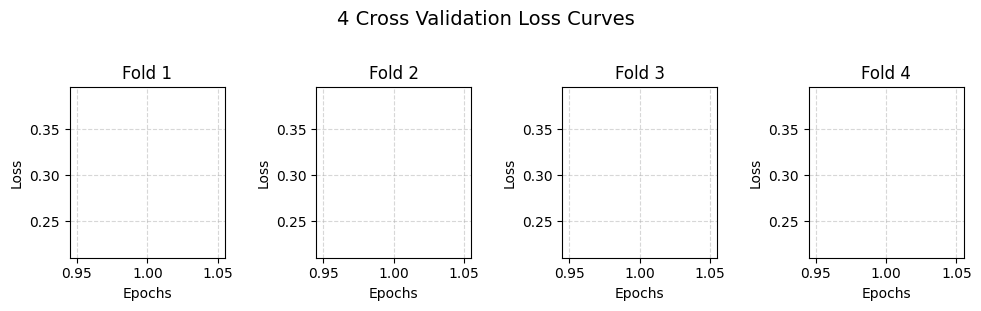

In [37]:
plot_loss_curves(p_losses)

In [38]:
ph.get_sparsity(p_trained_model) # Percentage of weights removed

89.99997671799692

In [39]:
test_model(model=p_trained_model,test_loader=test_loader)

Test Evaluation
Accuracy: 0.93
Test precision: 0.79
Test recall: 0.54
Test f1-score: 0.64
Finished test evaluation!


### Determining CIEs

In [40]:
def get_cie_count(model_1, model_2, test_loader):
        print("Determining CIEs:")

        model_1.eval()
        model_2.eval()
        cie_list = []

        with torch.no_grad():
            for imgs, lbls, sample_name in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)

                outputs_1 = model_1(imgs).squeeze(1)
                predicted_1 = (torch.sigmoid(outputs_1) > 0.5).float()

                outputs_2 = model_2(imgs).squeeze(1)
                predicted_2 = (torch.sigmoid(outputs_2) > 0.5).float()

                disagree_mask = (predicted_1 != predicted_2)

                for i in range(len(sample_name)):
                     if disagree_mask[i]:
                          cie_list.append(sample_name[i])

        print(f"Number of CIEs: {len(cie_list)}")

        return cie_list

In [41]:
random_model = ResNet18().to(device)

In [42]:
test_model(random_model, test_loader=test_loader)

Test Evaluation
Accuracy: 0.12
Test precision: 0.12
Test recall: 1.00
Test f1-score: 0.21
Finished test evaluation!


In [44]:
cie_list = get_cie_count(np_trained_model, random_model, test_loader=test_loader)

Determining CIEs:
Number of CIEs: 155


In [45]:
cie_list

['086950.jpg',
 '168221.jpg',
 '169650.jpg',
 '024397.jpg',
 '066083.jpg',
 '075330.jpg',
 '052209.jpg',
 '088532.jpg',
 '121037.jpg',
 '035804.jpg',
 '038248.jpg',
 '024909.jpg',
 '172381.jpg',
 '143369.jpg',
 '142906.jpg',
 '089380.jpg',
 '183964.jpg',
 '125513.jpg',
 '151422.jpg',
 '110693.jpg',
 '107190.jpg',
 '046548.jpg',
 '100808.jpg',
 '023504.jpg',
 '193845.jpg',
 '059745.jpg',
 '139355.jpg',
 '002885.jpg',
 '020076.jpg',
 '179256.jpg',
 '003439.jpg',
 '043024.jpg',
 '010793.jpg',
 '073516.jpg',
 '154238.jpg',
 '075194.jpg',
 '133783.jpg',
 '098595.jpg',
 '170238.jpg',
 '051320.jpg',
 '057059.jpg',
 '093312.jpg',
 '091907.jpg',
 '056155.jpg',
 '053703.jpg',
 '067226.jpg',
 '099404.jpg',
 '016343.jpg',
 '061327.jpg',
 '144487.jpg',
 '063478.jpg',
 '010580.jpg',
 '036574.jpg',
 '082055.jpg',
 '188772.jpg',
 '087235.jpg',
 '175734.jpg',
 '097991.jpg',
 '163277.jpg',
 '170551.jpg',
 '153892.jpg',
 '191223.jpg',
 '029348.jpg',
 '110849.jpg',
 '161150.jpg',
 '049290.jpg',
 '142810.j